# Importing libraries

In [1]:
using CSV
using DataFrames
using Plots
using Trapz

# Importing dataset

In [2]:
data = CSV.read("./BldgAkW1Day.csv");

In [3]:
time_unit = 15/60 # in hours
data[:Time, ] = collect(range(0., step=time_unit, length=length(data[:Time, ])));

In [4]:
head(data)

,Time,kW
,Float64,Float64
1,0.0,221.88
2,0.25,217.56
3,0.5,216.6
4,0.75,218.64
5,1.0,215.88
6,1.25,218.16


# Visual checking

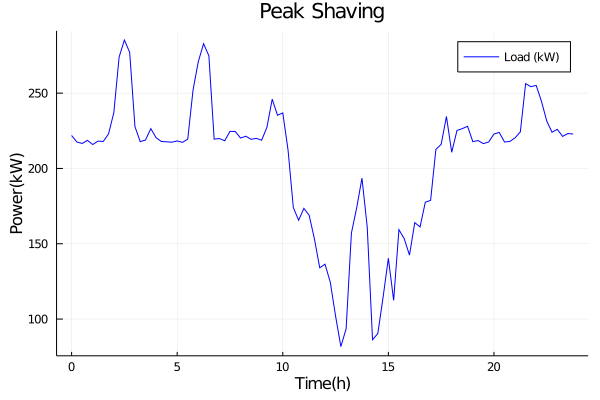

In [5]:
plot(data[:Time, ], data[:kW, ], color=:blue, label="Load (kW)")
title!("Peak Shaving")
ylabel!("Power(kW)")
xlabel!("Time(h)")

# Methodology

# Objective function

In [6]:
# Objective function
# Params:
#    - Scenario : :withoutCharging, :intermediateCharging, :standbyMode,
#                 :optimalChargingMode, :constantPower
#    - Cbatt    : Battery energy capacity
#    - x        : Shave level
#    - L        : Load
#    - soc0     : Initial state of charge
#    - socN     : state of charge after the operation
function objfunc(scenario::Symbol, Cbatt::T, x::Union{T, Vector{T}}, t::Vector{T}, L::Vector{T};
                 soc0=0., socN=1.) where {T}
    
    # Compute the integral between load and shave level (in KWh)
    function compute_integral(i::Vector{Int})
        return trapz(t[i], L[i])
    end
    
    # Difference between load an shave level
    diff = L .- x
    # negative indices
    neg_pos = filter(i->diff[i]<=0, 1:length(diff))
    # positives indices
    pos_pos = filter(i->diff[i]>=0, 1:length(diff))
    
    # Scenario 1: Peak shaving without charging
    if scenario == :withoutCharging
        diff[neg_pos] .= 0.
        return abs(Cbatt - trapz(t, diff))
    end
    
    # Scenario 2: Peak shaving with intermediate charging
    # Scenario 3: Standby mode
    if scenario == :intermediateCharging ||
       scenario == :standby
           return abs(Cbatt - trapz(t, diff))
    end
    
    # Scenario 4: Optimal charging mode
    if scenario == :optimalCharging
        diff[pos_pos] .= 0.
        return abs(Cbatt + trapz(t, diff))
    end
    
    # Scenario 5: Charging with constant power
    if scenario == :constantPower
        return abs(Cbatt * (socN .- soc0) .+ trapz(t, diff))
    end
    
    throw(DomainError("The objective function is not implement for scenario==$scenario"))
end

objfunc (generic function with 1 method)

# Optimization Algorithm

In [7]:
# Optimization algorithm
# Parameters:
#    - scenario   : Scenario
#    - L          : Load
#    - Cbatt      : Battery energy capacity
#    - step       : Number of steps for generating the shave level range
#    - limit      : Acceptable limit
#    - rtol       : Tolerance
#    - soc0, socN : Battery state of charge
# Return :
#    - best_pshave : Best shave level
function optimize(scenario::Symbol, t::Vector{T}, L::Vector{T}, Cbatt::T, limit::T;
                  itermax = 200, step=1.0, rtol=1e-3, soc0 = 0., socN = 1.0) where {T}
    
    # Can be solved analytically for constant power charging
    if scenario == :constantPower
        N = length(L)
        # (t[N] - t[1]) * add_power = (socN-soc0) * Cbatt
        add_power = (socN - soc0) * Cbatt / (t[N] - t[1])
        println("Best shave level = [$(L[1]+add_power), ..., $(L[N]+add_power)]")
        return L .+ add_power
    end

    # The best shave level is the load
    if scenario == :standby
        println("Best shave level = [$(L[1]), ..., $(L[length(L)])]")
        return L
    end
    
    # Generate a vector covering the whole shave level
    min_pshave = ceil(min(L...))
    max_pshave = floor(max(L...))
    pshave_level = collect(range(min_pshave, max_pshave, step=step))
    # Compute the errors
    errors = [objfunc(scenario, Cbatt, x, t, L) for x in pshave_level]
    # Find min_error and it's index
    min_error, index = findmin(errors)
    # Initialize the shave level
    best_pshave0 = 0.
    best_pshave = pshave_level[index]
    
    optimized = false
    iter = 1
    while !optimized
        if iter > itermax
            println("The optimization algorihtm did not converge.")
            return
        end
        if min_error < limit
            println("Best shave level = $best_pshave found after $iter iterations.")
            optimized = true
            break
        end
        if abs(best_pshave0 - best_pshave) < rtol
            println("The optimization algorihtm did not converge after $iter iterations.")
            return
        else
            step = step/2.0
            # Update shave level
            pshave_level = collect(range(pshave_level[index-1], pshave_level[index+1], step=step))
            # Compute the errors
            errors = [objfunc(scenario, Cbatt, x, t, L) for x in pshave_level]
            # Find min_error and it's index
            min_error, index = findmin(errors)
            # save the previous best shave level
            best_pshave0 = best_pshave
            # Find the best shave level
            best_pshave = pshave_level[index]
        end
        iter += 1
    end
    return best_pshave
end

optimize (generic function with 1 method)

# Results

## Parameters

In [8]:
# Battery capacity (kW)
Cbatt = 1000.
# Acceptable limit
limit = 10.;

## Genrate shave level

In [9]:
function generate_shave_level(scenario::Symbol, t::Vector{T}, L::Vector{T}, Cbatt::T;
                              step=1.0, soc0=0., socN=1.) where {T}
    if scenario == :withoutCharging ||
       scenario == :intermediateCharging ||
       scenario == :optimalCharging
           min_pshave = ceil(min(L...))
           max_pshave = floor(max(L...))
           return collect(range(min_pshave, max_pshave, step=step))
    end
    if scenario == :standby
        return L
    end
    if scenario == :constantPower
        N = length(L)
        # (t[N] - t[1]) * range_max = (socN-soc0) * Cbatt
        range_max = (socN - soc0) * Cbatt / (t[N] - t[1])
        r = Vector{Vector{T}}()
        for x in collect(range(0., range_max * 2, step=step))
            push!(r, L.+ x)
        end
        return r
    end
    
    throw(DomainError("generate_shave_level function not implemented for scenario=$scenario"))
end

generate_shave_level (generic function with 1 method)

## Plot the objective function

In [10]:
function plot_objfunc(scenario::Symbol, Cbatt::T, t::Vector{T}, L::Vector{T};
                      step=1.0, soc0=.0, socN=1.) where {T}
    pshave_level = generate_shave_level(scenario, t, L, Cbatt, step=step, soc0=soc0, socN=socN)
    errors = [objfunc(scenario, Cbatt, x, t, L, soc0=soc0, socN=socN) for x in pshave_level];
    if scenario == :constantPower
        plot([x[1] - L[1] for x in pshave_level], errors, color=:blue, label="kW, $scenario")
        xlabel!("Power(kW)")
    else
        plot(pshave_level, errors, color=:blue, label="kW, $scenario")
        xlabel!("Pshave(kW)")
    end
    title!("Objective function")
    ylabel!("error(kW)")
end

plot_objfunc (generic function with 1 method)

## Plot the load and the shave level

In [11]:
function plot_load_pshave(t::Vector{T}, L::Vector{T}, x::Union{T, Vector{T}}) where {T}
    plot(t, L, label="kW")
    if typeof(x) == T
        plot!(t, repeat([x], length(t)), label="Shave level (kW)")
    else
        plot!(t, x, label="Shave level (kW)")
    end
    ylabel!("Power(kW)")
    xlabel!("Time(h)")
end

plot_load_pshave (generic function with 1 method)

## Scenario 1. Without Charging

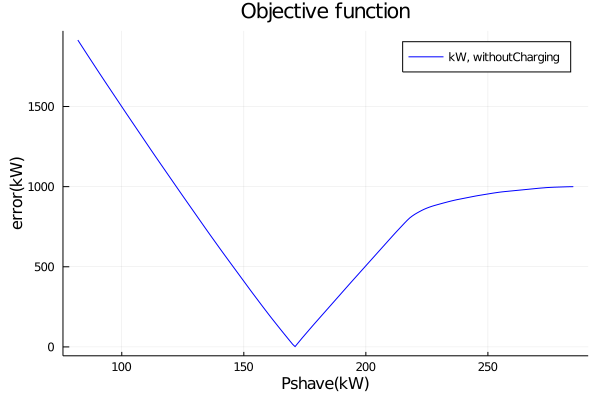

In [12]:
# Plot the objective function
plot_objfunc(:withoutCharging, Cbatt, data[:Time, ], data[:kW, ])

In [13]:
# Find the best shave level
best_pshave_scenario1 = optimize(:withoutCharging, data[:Time, ], data[:kW, ], Cbatt, limit);

Best shave level = 171.0 found after 1 iterations.


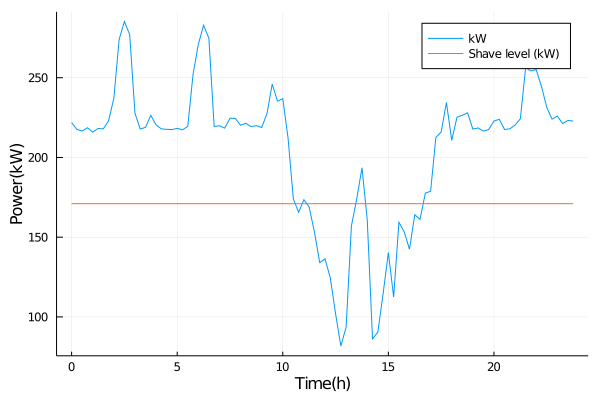

In [14]:
# Plot the load and the best shave level
plot_load_pshave(data[:Time, ], data[:kW, ], best_pshave_scenario1)

## Scenario 2. Intermediate Charging

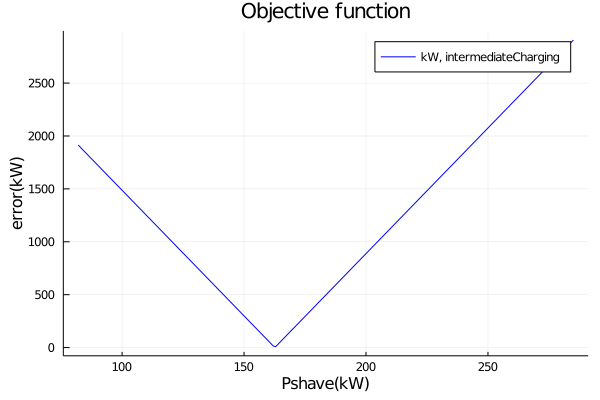

In [15]:
# Plot the objective function
plot_objfunc(:intermediateCharging, Cbatt, data[:Time, ], data[:kW, ])

In [16]:
# Find the best shave level
best_pshave_scenario2 = optimize(:intermediateCharging, data[:Time, ], data[:kW, ], Cbatt, limit);

Best shave level = 163.0 found after 1 iterations.


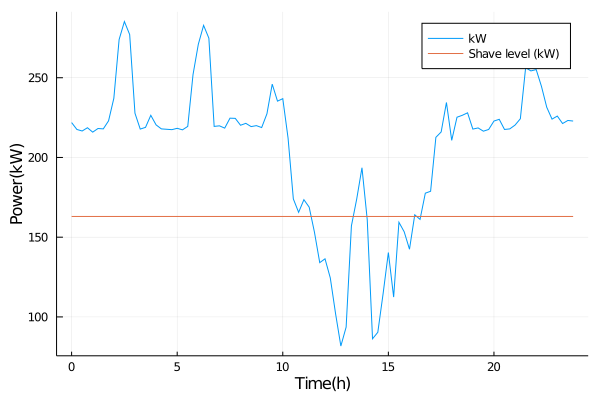

In [17]:
# Plot the load and the best shave level
plot_load_pshave(data[:Time, ], data[:kW, ], best_pshave_scenario2)

## Scenario 3. Standby mode

In [18]:
# Find the best shave level
best_pshave_scenario3 = optimize(:standby, data[:Time, ], data[:kW, ], Cbatt, limit);

Best shave level = [221.88, ..., 222.84]


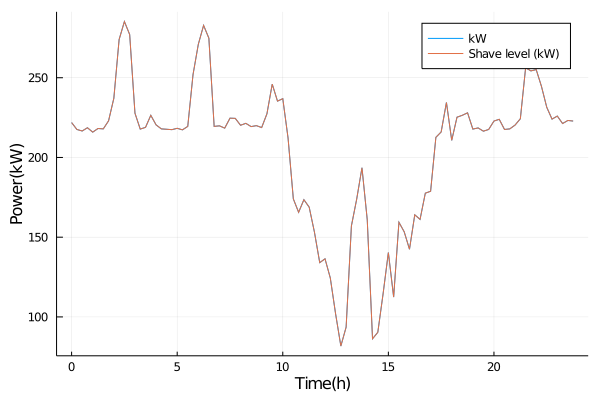

In [19]:
# Plot the load and the best shave level
plot_load_pshave(data[:Time, ], data[:kW, ], best_pshave_scenario3)

##  Scenario 4. Optimal charging

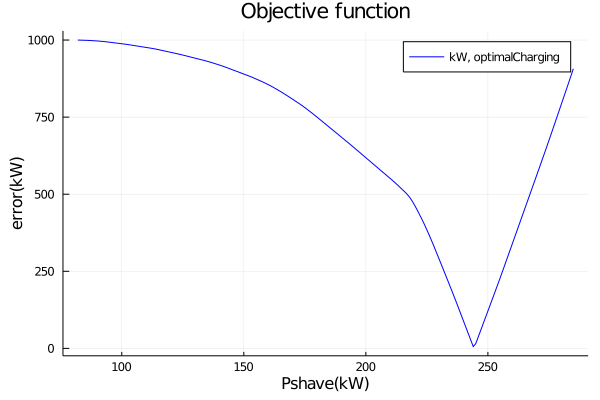

In [20]:
# Plot the objective function
plot_objfunc(:optimalCharging, Cbatt, data[:Time, ], data[:kW, ], soc0=0., socN=1.)

In [21]:
# Find the best shave level
best_pshave_scenario4 = optimize(:optimalCharging, data[:Time, ], data[:kW, ], Cbatt, limit);

Best shave level = 244.0 found after 1 iterations.


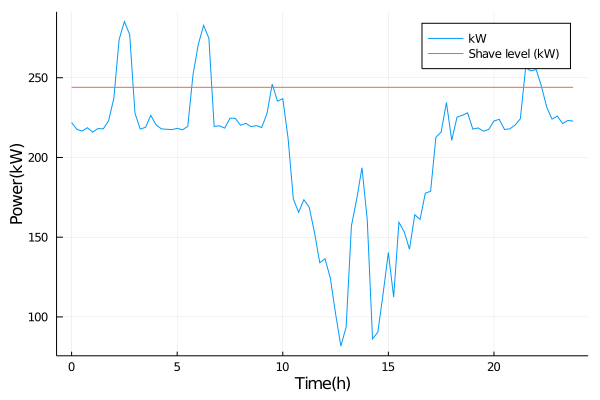

In [22]:
# Plot the load and the best shave level
plot_load_pshave(data[:Time, ], data[:kW, ], best_pshave_scenario4)

## Scenario 5. Charging with constant power

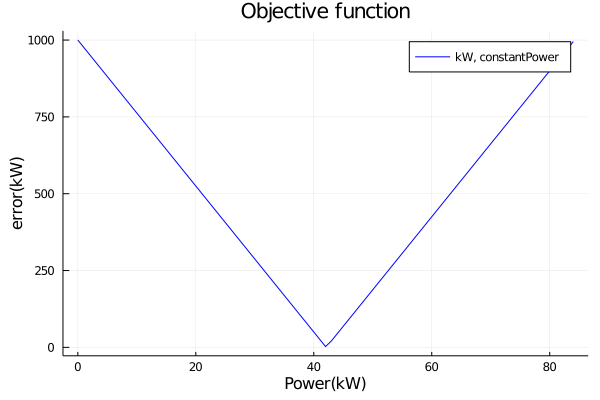

In [23]:
# Plot the objective function
plot_objfunc(:constantPower, Cbatt, data[:Time, ], data[:kW, ], soc0=0., socN=1.)

In [24]:
# Find the best shave level
best_pshave_scenario5 = optimize(:constantPower, data[:Time, ], data[:kW, ], Cbatt, limit, soc0=0., socN=1.);

Best shave level = [263.98526315789474, ..., 264.9452631578947]


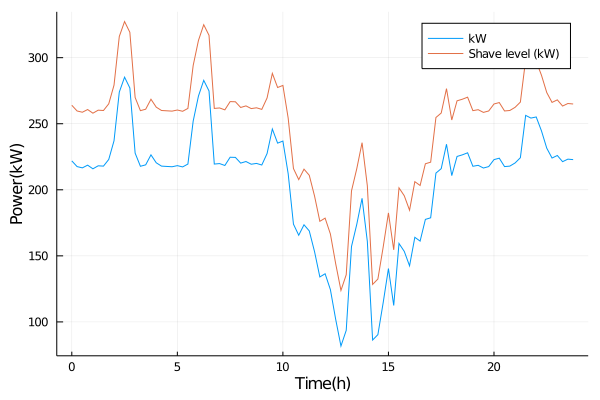

In [25]:
# Plot the load and the best shave level
plot_load_pshave(data[:Time, ], data[:kW, ], best_pshave_scenario5)

## Estimate the SOC

In [26]:
# Estimate the battery state of charge (SOC)
# Parameters:
#    - scenario : Scenario
#    - t        : Time (h)
#    - L        : Load (kW)
#    - x        : Shave level
#    - soc0     : Battery initial state of charge (%)
#    - Cbatt    : Battery capacity
function estimate_soc(scenario::Symbol, t::Vector{T}, L::Vector{T}, x::Union{T, Vector{T}},
                      soc0::T, Cbatt::T) where {T}
    # Standby mode
    if scenario == :standby
        return repeat([soc0], length(L))
    end

    # Charge/Decharge current
    I = x .- L
    N = length(I)

    if scenario == :withoutCharging
        I[filter(i->I[i]>=0, 1:N)] .= 0.
    elseif scenario == :optimalCharging
        I[filter(i->I[i]<=0, 1:N)] .= 0.
    end

    soc = Vector{T}(undef, N)
    # Compute the soc
    soc[1] = soc0
    for i in 2:N
        soc[i] = soc0 + trapz(t[1:i], I[1:i] ./ Cbatt)
    end
    
    return soc
end

estimate_soc (generic function with 1 method)

### Plot the Load and the SOC

In [27]:
# Plot the state of charge and the load
function plot_soc_load(scenario::Symbol, t::Vector{T}, L::Vector{T}, pshave_level::Union{T, Vector{T}},
                  soc0::T, Cbatt::T) where {T}
    # Estimate the soc
    soc = estimate_soc(scenario, t, L, pshave_level, soc0, Cbatt)
    # Plot the SOC
    plot(t, soc * 100., color=:black, label="SOC")
    # Plot the load
    plot!(t, L, color=:blue, label="Laod (kW)")
    # plot the shave level
    if typeof(pshave_level) == T
        plot!(t, repeat([pshave_level], length(L)), color=:red, label="Best shave level")
    else
        plot!(t, pshave_level, color=:red, label="Best shave level")
    end
    title!("Peak Shaving")
    ylabel!("Power(kW)")
    xlabel!("Time(h)")
end

plot_soc_load (generic function with 1 method)

##  Scenario 1. Without charging

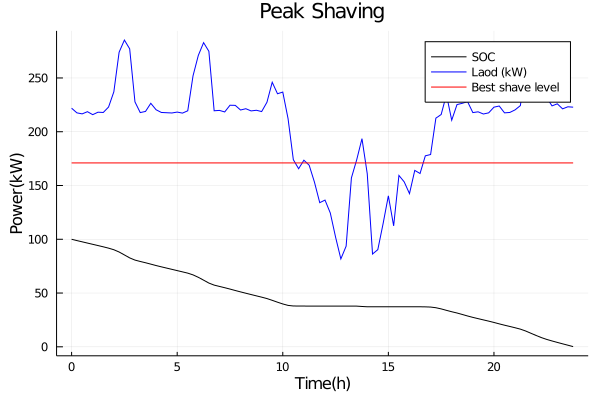

In [28]:
plot_soc_load(:withoutCharging, data[:Time, ], data[:kW, ], best_pshave_scenario1, 1., Cbatt)

##  Scenario 2. Intermediate charging

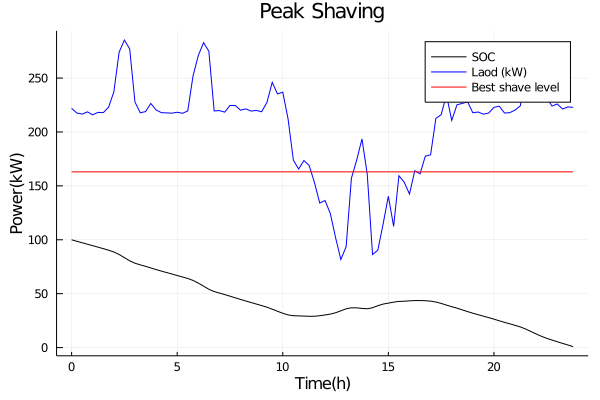

In [29]:
plot_soc_load(:intermediateCharging, data[:Time, ], data[:kW, ], best_pshave_scenario2, 1., Cbatt)

##  Scenario 3. Standby mode

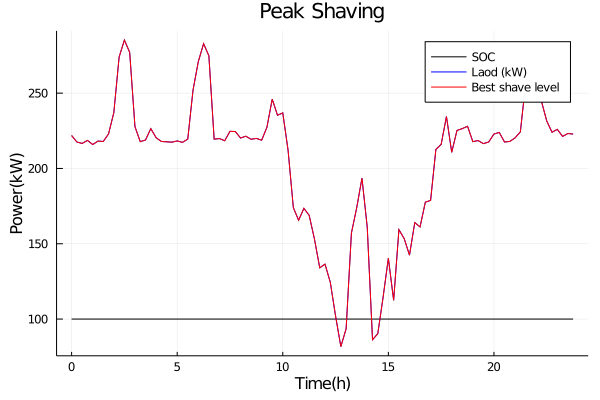

In [30]:
plot_soc_load(:standby, data[:Time, ], data[:kW, ], best_pshave_scenario3, 1., Cbatt)

##  Scenario 4. Optimal charging

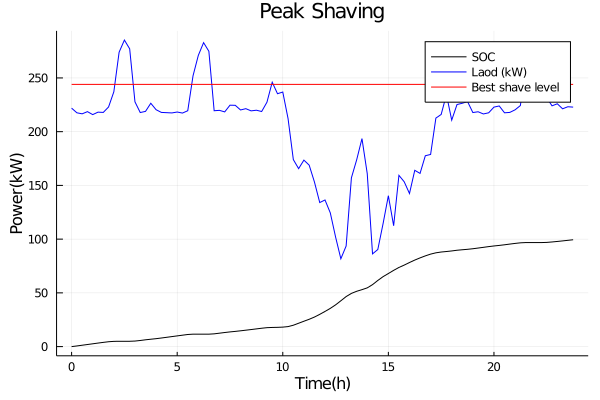

In [31]:
plot_soc_load(:optimalCharging, data[:Time, ], data[:kW, ], best_pshave_scenario4, 0., Cbatt)

##  Scenario 5. Charging with constant power

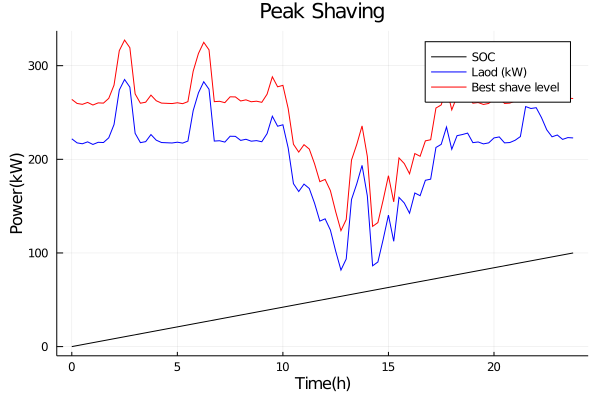

In [32]:
plot_soc_load(:constantPower, data[:Time, ], data[:kW, ], best_pshave_scenario5, 0., Cbatt)